### Имеются результаты A/B теста игрового приложения, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим?

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import scipy.stats as stats

In [2]:
# скачиваем исходные данные Проект_1_Задание_2.csv

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

users = pd.read_csv(download_url, sep=';')  # исходный датафрэйм с информацией о пользователях

**Предварительный анализ данных**

In [3]:
users.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
users.testgroup.unique()  # убедились, что данные приведены действительно только для 2 групп

array(['b', 'a'], dtype=object)

In [5]:
users.dtypes  # типы данных корректные, ничего не требуется преобразовывать

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [6]:
users.isna().sum()  # отсутствующих значений нет

user_id      0
revenue      0
testgroup    0
dtype: int64

In [7]:
users[users.duplicated()]  # нет дубликатов

,user_id,revenue,testgroup


In [8]:
users.revenue.sort_values()  # диапазон суммы выручки от 0 до 37433

0             0
269217        0
269216        0
269215        0
269214        0
          ...  
142804    37379
21585     37385
65077     37394
196601    37407
101861    37433
Name: revenue, Length: 404770, dtype: int64

Перед тем, как проводить расчеты, нужно определить, какая из групп (a или b) является тестовой, какая - контрольной. Мы знаем, что в контрольной группе 202103 пользователей, а в тестовой – 202667.

In [9]:
users.groupby('testgroup', as_index=False).agg({'user_id': 'nunique'})

,testgroup,user_id
0,a,202103
1,b,202667


Таким образом, группа "а" является контрольной. Для удобства переименуем группы.

In [10]:
users = users.replace({'testgroup':{'a': 'control', 'b': 'test'}})

In [11]:
users

,user_id,revenue,testgroup
0,1,0,test
1,2,0,control
2,3,0,control
3,4,0,test
4,5,0,test
...,...,...,...
404765,404766,0,control
404766,404767,0,test
404767,404768,231,control
404768,404769,0,control


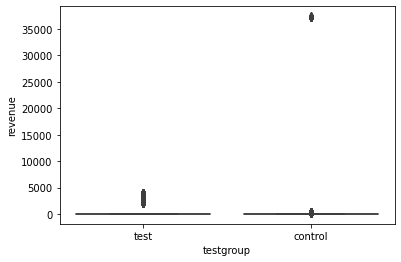

In [12]:
# посмотрим на распределение данных на графике боксплот
sns.boxplot(x='testgroup', y='revenue', data=users)  

На графике видно, что значения из тестовой группы имеют более однородные значения, а в контрольной группе есть заметный выборос. Также видно, что суммы чеков в тестовой группе выше, чем в контрольной. Так как на основе имеющихся данных мы не можем сказать, являются ли эти выбросы ошибкой или вариантом нормы, то удалять их из выборки не будем. Считаем, что данные в выборке корректны и выборка репрезентативна

###  Решение задачи. Анализ результатов A/B теста

**Обоснование выбора метрик** Выбор метрик в первую очередь обусловлен имеющейся исходной информацией.<br>

*Выручка пользователей и общее количество пользователей:*<br>
- ARPU в тестовой и контрольной группе<br>

*Количество платящих пользователей:*<br>
- ARPPU в тестовой и контрольной группе<br>
- Доля платящих пользователей в каждой группе<br>

**Анализ ARPU в тестовой и контрольной группе**

Рассчитаем ARPU для каждой группы.

In [13]:
users.query('testgroup == "test"').revenue.mean()

26.75128659327863

In [14]:
users.query('testgroup == "control"').revenue.mean()

25.413719736965806

ARPU в тестовой группе выше на 5%. Проверим, является ли эта разница статистически значимой. Так как данные являются количественными, для анализ будем использовать t-тест и бутстрап.<br>

В рамках t-теста формулируются две гипотезы:<br>
Н_0 – в выборках значимого различия между средними значениями нет<br>
H_1 – средние в выборках не равны (альтернативная гипотеза)<br>
Для сравнения средних с помощью t-критерия нужно, чтобы соблюдался ряд требований, в частности, распределение значений должно быть нормальным, дисперсии внутри групп должны быть примерно одинаковы (требование гомогенности дисперсий).

Проверим две группы данных на соответствие требованиям.

In [15]:
test_group = users.query('testgroup == "test"')  # выборка пользователей из тестовой группы

In [16]:
control_group = users.query('testgroup == "control"')  # выборка пользователей из контрольной группы

In [17]:
test_group.revenue.sort_values()

0            0
269081       0
269084       0
269085       0
269086       0
          ... 
85614     3995
185454    3999
36472     3999
34357     4000
149618    4000
Name: revenue, Length: 202667, dtype: int64

In [18]:
control_group.revenue.sort_values()  # максимальные значения в контрольной группе намного выше, чем в тестовой

1             0
269294        0
269295        0
269299        0
269300        0
          ...  
142804    37379
21585     37385
65077     37394
196601    37407
101861    37433
Name: revenue, Length: 202103, dtype: int64

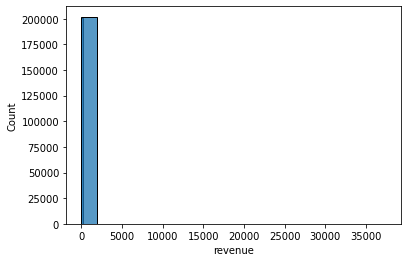

In [19]:
sns.histplot(test_group.revenue, kde=False)  # визуально графики малоинформативны из-за неоднородности данных
sns.histplot(control_group.revenue, kde=False)

Проведем дополнительные исследования - построим графики QQ-Plot

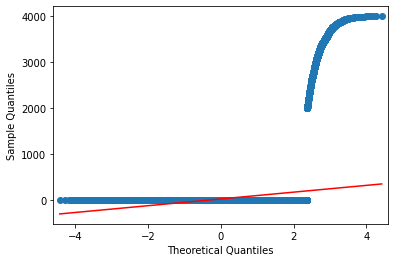

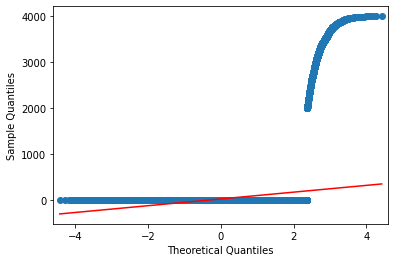

In [20]:
sm.qqplot(test_group.revenue, line="r")  # распределение в группе test отличается от нормального

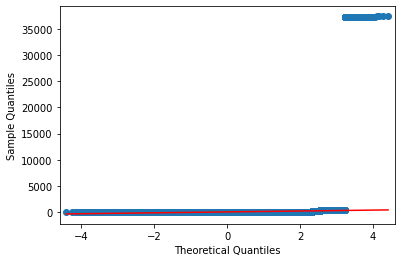

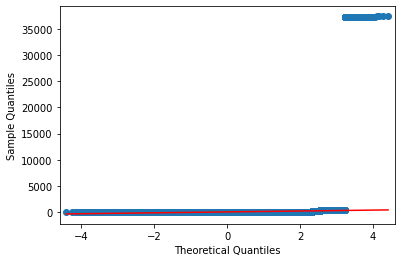

In [21]:
sm.qqplot(control_group.revenue, line="r")  # распределение в группе control отличается от нормального

Несмотря на полученные графики, все равно проверим гипотезу о нормальности с помощью тестов. Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности. Поэтому использовалась функция scipy.stats.normaltest() - она больше адаптирована к большим выборкам
Нулевая гипотеза теста - распределение нормальное. Альтернативная гипотеза теста - распределение отличается от нормального

In [22]:
scipy.stats.normaltest(test_group.revenue)  # проверка на нормальноссть распределения для тестовой группы. 

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

In [23]:
scipy.stats.normaltest(control_group.revenue)  # проверка на нормальноссть распределения для контрольной группы. 

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

Полученные значения p-value меньше порога 0,05, следовательно, тесты показывают, что мы не можем принять нулевую гипотезу, значения в группах распределены ненормально

Тестируем различие в дисперсиях с помощью критерия Левена. Нулевая гипотеза для этого теста: дисперсии в двух выборках не имеют значимых различий. Альтернативная гипотеза - дисперсии в выборках значимо отличаются

In [24]:
stats.levene(test_group.revenue, control_group.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Так как p-значение теста Левена больше принятого уровня значимости 0.05, у нас нет оснований отклонить нулевую гипотезу и мы делаем вывод о том, что дисперсии в двух выборках не имеют значимых различий

В итоге, одно из требований  при применении t-критерия не выполяется, распределение не является нормальным. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках

In [25]:
stats.ttest_ind(test_group.revenue, control_group.revenue)

Ttest_indResult(statistic=0.6242026493616787, pvalue=0.532494858971837)

Полученное в результате t-теста p-значение выше уровня значимости 0.05, следовательно, у нас нет оснований отклонить нулевую гипотезу Н_0 – в группах значимых различий между средними значениями нет.<br>
**Вывод:**  по данным t-теста средние значения ARPU для каждой группы статистически значимо не отличаются.

Проверим гипотезу о равенстве средних с помощью методики бутстрапа. 
Гипотезы:<br> 
Н_0 – в генеральной совокупности различия между средними значениями нет<br>
H_1 – средние значения в генеральной совокупности не равны<br>
Главный критерий отклонения нулевой гипотезы - доверительный интервал не включает в себя 0, в этом случае верна альтернативная гипотеза.

In [26]:
mean_diff = []

for i in range(5000):
    sample_data_0 = test_group["revenue"].sample(frac=1, replace=True)
    sample_mean_0 = sample_data_0.mean()

    sample_data_1 = control_group["revenue"].sample(frac=1, replace=True)
    sample_mean_1 = sample_data_1.mean()

    sample_mean_diff = sample_mean_0 - sample_mean_1
    mean_diff.append(sample_mean_diff)

In [27]:
pd.Series(mean_diff).quantile(0.975)

5.45548038912343

In [28]:
pd.Series(mean_diff).quantile(0.025)

-2.955469795790421

**Вывод:**  Так как полученный интервал включает 0, принимаем нулевую гипотезу, которая говорит о том, что статистически значимые отличия в средних значениях в тестовой и контрольной группах отсутствуют

**Анализ ARPPU в тестовой и контрольной группе**

Рассчитаем показатель ARPPU для двух групп. Выберем только платящих пользователей и рассчитаем средний чек

In [29]:
test_group.query('revenue > 0').revenue.mean()

3003.6581717451522

In [30]:
control_group.query('revenue > 0').revenue.mean()

2663.9984439834025

In [31]:
3003.6581717451522 / 2663.9984439834025

1.1274999722799635

Средний чек на одного платящего пользователя выше в тестовой группе на 12,7%. Чтобы понять, является ли эта разница статистически значимой, также как и в предыдущем шаге будем использовать t-тест и бутстрап. Нулевые гипотезы для тестов идентичны, поэтому повторно подробно их описывать не будем

In [32]:
paying_test_group = users.query('testgroup == "test" & revenue > 0')  # выборка платящих пользователей из тестовой группы

In [33]:
paying_control_group = users.query('testgroup == "control" & revenue > 0')  # выборка платящих пользователей из контрольной группы

Проверка выборок на нормальность

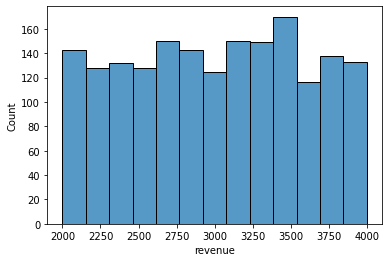

In [34]:
sns.histplot(paying_test_group.revenue, kde=False)  # на графике суммы выручки довольно равномерные

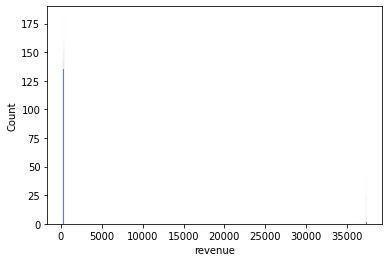

In [35]:
sns.histplot(paying_control_group.revenue, kde=False) 
# визуально график контрольной группы малоинформативен из-за большого разброса значений

Проведем дополнительные исследования - построим графики QQ-Plot

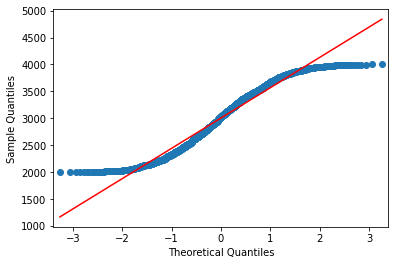

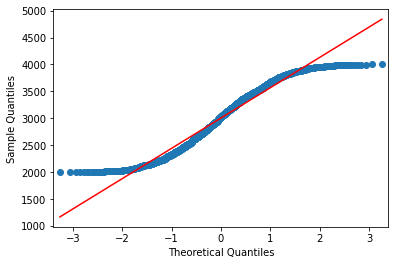

In [36]:
sm.qqplot(paying_test_group.revenue, line="r")  # распределение в группе test отличается от нормального

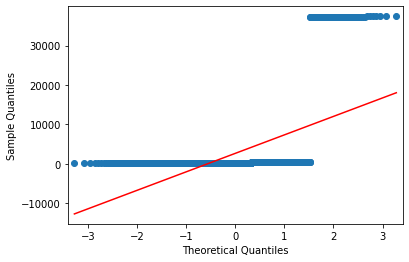

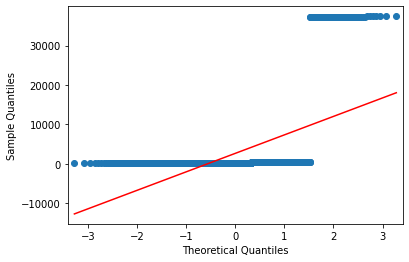

In [37]:
sm.qqplot(paying_control_group.revenue, line="r")  # распределение в группе control отличается от нормального

In [38]:
scipy.stats.normaltest(paying_test_group.revenue)  # проверка на нормальноссть распределения для тестовой группы. 

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

In [39]:
scipy.stats.normaltest(paying_control_group.revenue)  # проверка на нормальноссть распределения для контрольной группы. 

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

Полученные значения p-value для двух групп меньше порога 0,05, следовательно, тесты показывают, что мы не можем принять нулевую гипотезу, значения в группах распределены ненормально

Тестируем различие в дисперсиях с помощью критерия Левена. Нулевая гипотеза для этого теста: дисперсии в двух выборках не имеют значимых различий. Альтернативная гипотеза - дисперсии в выборках значимо отличаются

In [40]:
stats.levene(paying_test_group.revenue, paying_control_group.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Так как p-значение теста Левена меньше принятого уровня значимости 0.05, отклоняем нулевую гипотезу и делаем вывод о том, что дисперсии в двух выборках имеют значимые различия

В итоге, в данном случае оба из основных требований  при применении t-критерия не выполяется, распределение не является нормальным и дисперсии не однородны. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках.

По умолчанию stats.ttest_ind предполагает равные дисперсии генеральной совокупности. Если установлен параметр equal_var=False, то это не предполагает равных дисперсий генеральной совокупности (поправка Уэлча).

In [41]:
stats.ttest_ind(paying_test_group.revenue, paying_control_group.revenue, equal_var=False)

Ttest_indResult(statistic=1.6446302664300838, pvalue=0.10020780398916015)

Полученное в результате t-теста p-значение выше уровня значимости 0.05, следовательно, у нас нет оснований отклонить нулевую гипотезу Н_0 – в выборках значимых различий между средними значениями нет.
**Вывод:**  по данным t-теста средние значения ARPPU для каждой группы статистически значимо не отличаются.

Проведем анализ данных с помощью метода бутстрап.<br> 
Гипотезы:<br>
Н_0 – в выборках различия между средними значениями нет<br>
H_1 – средние значения в выборках не равны (альтернативная гипотеза)<br>
Главный критерий отклонения нулевой гипотезы - доверительный интервал не включает в себя 0, в этом случае верна альтернативная гипотеза.

In [42]:
mean_diff = []

for i in range(5000):
    sample_data_0 = paying_test_group["revenue"].sample(frac=1, replace=True)
    sample_mean_0 = sample_data_0.mean()

    sample_data_1 = paying_control_group["revenue"].sample(frac=1, replace=True)
    sample_mean_1 = sample_data_1.mean()

    sample_mean_diff = sample_mean_0 - sample_mean_1
    mean_diff.append(sample_mean_diff)

In [43]:
pd.Series(mean_diff).quantile(0.975)

738.7604137452445

In [44]:
pd.Series(mean_diff).quantile(0.025)

-55.66751017229673

**Вывод:**  Так как полученный интервал включает 0, принимаем нулевую гипотезу, которая говорит о том, что статистически значимые отличия в средних значениях в выборках отсутствуют

**Анализ доли платящих пользователей в каждой группе (конверсия в платящих пользователей)**

Так как у нас есть две категориальные переменные (платящий/не платящий), используем критерий Хи-квадрат.
Проверим нулевую гипотезу: в двух группах распределение платящих и не платящих пользователей одинаковое. Альтернативной будет являться гипотеза, что различные наборы акционных предложений влияют на распределение платящих и не платящих пользователей.

In [45]:
# заменим значения прибыли на 1, чтобы создать 2 группы пользователей. 0 - не платящие, 1 - платящие
users['revenue'] = np.where(users.revenue>0, 1, users.revenue)

In [46]:
cross = pd.crosstab(users.revenue, users.testgroup)  # таблица сопряженности

In [47]:
cross

testgroup,control,test
revenue,,
0,200175,200862
1,1928,1805


In [48]:
chi2_contingency(cross)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

Полученное значение p-value = 0.036, что меньше порога значимости 0.05, следовательно, нулевую гипотезу отклоняем.
**Вывод:** набор акционных предложений в тестовой группе привел к статистически значимому изменению конверсии в платящих пользователей

Рассчитаем долю платящих пользователей в каждой группе

In [49]:
1805 / 202667  # тестовая группа

0.008906235351586593

In [50]:
1928 / 202103  # контрольная группа

0.009539690157988749

In [51]:
0.009539690157988749 / 0.008906235351586593

1.0711248671740197

В контрольной группе доля платящих игроков оказалась выше на 7%, чем в тестовой

**Общие выводы по результатам А/В теста:** <br>
1) средняя сумма чека на одного пользователя (ARPU) в тестовой группе выше на 5% по сравнению с контрольной, но разница не является статистически значимой<br>
2) средняя сумма чека на одного платящего пользователя (ARPPU) выросла в тестовой группе на 12,7% по сравнению с контрольной, но разница не является статистически значимой<br>
3) доля платящих игроков в контрольной группе выше на 7% по сравнению с тестовой, разница статистически значима<br>
В целом, можно сделать вывод, что разные наборы акционных предложений не привели к статистически значимому изменению выручки, но в контрольной группе выше конверсия в платящего пользователя.<br>
